# Deep learning from scratch: homework 3

### General instructions

Complete the exercises listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself.  Feel free to add any necessary cells.  

Included with the notebook are 

- a custom utilities file called `custom_utils.py` that provides various plotting functionalities (for unit tests to help you debug) as well as some other processing code


- datasets for exercises: `unnorm_linregress_data.csv`, `highdim_multirange_linregress.csv`, `student_debt.csv`, and  `noisy_sin_sample.csv`

be sure you have these files located in the same directory where you put this notebook to work!

### When submitting this homework:
    
**Make sure all output is present in your notebook prior to submission**

In [1202]:
# import autograd functionality
import autograd.numpy as np
from autograd.util import flatten_func
from autograd import grad as compute_grad   

# import custom utilities
import custom_utilities as util

# import various other libraries
import copy
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Feel free to use the following ``gradient_descent`` function below for this exercise.

In [1203]:
# gradient descent function
def gradient_descent(g,w,alpha,max_its,beta,version):    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    w_hist.append(unflatten(w))

    # start gradient descent loop
    z = np.zeros((np.shape(w)))      # momentum term
    
    # over the line
    for k in range(max_its):   
        # plug in value into func and derivative
        grad_eval = grad(w)
        grad_eval.shape = np.shape(w)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm
            
        # take descent step with momentum
        z = beta*z + grad_eval
        w = w - alpha*z

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist

#### <span style="color:#a50e3e;">Exercise 3. </span>  Normalizing the input of multi-input features

Now that we have seen how normalizing the input of a single-input linear regression dataset gives us significant efficiency gains with gradient descent, and so should be used often in practice.  One can imagine how this concept might generalize to the general $N$ dimensional input case - probably something similar will happen!  

In this exercise you will explore this scenario of using input-normalization (also known as *feature scaling*) using the $N = 5$ dimensional linear regression dataset loaded in the next cell.  This dataset consists of a selection of random points taken from a random hyperplane in five dimensions, with absolutely no noise whatsoever added to the output. 

In [1204]:
# load data
data = np.loadtxt('highdim_multirange_linregress.csv',delimiter = ',')
x = data[:,:-1]
y = data[:,-1:]

Lets examine the numerical range of each input dimension / feature.  We can create this visualization for the $x_n$ dimension by plotting just the values of our input along this dimension (that is all values $x_{p,n}$ with $n$ fixed for $p=1,...,P$).   We do this for each input dimension / feature in the next cell.

In [1205]:
# a small Python function for plotting the distributions of input features
def feature_distributions(x,y,title):
    # create figure 
    fig, ax = plt.subplots(1, 1, figsize=(6,3))

    # loop over input and plot each individual input dimension value
    N = np.shape(x)[1]    # dimension of input
    for n in range(N):
        ax.scatter((n+1)*np.ones((len(y),1)),x[:,n],color = 'k',edgecolor = 'w')

    # set xtick labels 
    ticks = np.arange(1,N+1)
    labels = [r'$x_' + str(n+1) + '$' for n in range(N)]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, minor=False)

    # label axes and title of plot, then show
    ax.set_xlabel('input dimension / feature')
    ax.set_ylabel(r'$\mathrm{value}$',rotation = 0,labelpad = 20)
    ax.set_title(title)
    plt.show()

<IPython.core.display.Javascript object>


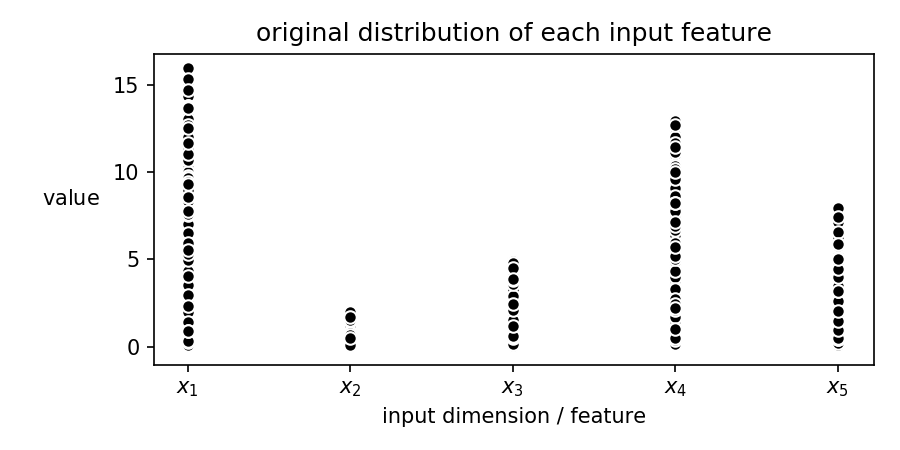

In [1206]:
# use the plotting function above
title = 'original distribution of each input feature'
feature_distributions(x,y,title)

As we can see in the plot above, the distributions of our input features here are way out of scale with each other, so we can expect gradient descent to converge quite slowly here - unless we normalize each input feature to have a similar distribution!

In analogy to the single-input case, here we should normalize *each feature individually* - that is each coordinate direction $x_n$.  What are we trying to avoid by doing this?  The (common) scenario where the distribution of input along each individual input dimensions widely varies, since this leads to a cost function with long narrow valley(s) that substantially slows down gradient descent.

Thus with the aim of standardizing each input direction - also referred to as a *feature* - we should normalize the $n^{th}$ input dimension of an $N$-input dimensional dataset $\left\{\mathbf{x}_p,y_p\right\}_{p=1}^N$ as 

\begin{equation}
x_{p,n} \longleftarrow \frac{x_{p,n} - \mu_n}{\sigma_n}
\end{equation}

where $x_{p,n}$ is the $n^{th}$ coordinate of point $\mathbf{x}_p$ and $\mu_n$ and $\sigma_n$ are the mean and standard deviation of the $n^{th}$ dimension of the data, respectively, and are defined as 

\begin{array}
\
\mu_n = \frac{1}{P}\sum_{p=1}^{P}x_{p,n} \\
\sigma_n = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_{p,n} - \mu_n \right)^2}
\end{array}

We could loop over each dimension and compute these values, or just use ``Numpy``'s built in broadcasting to compute them all simultaneously as shown in the next cell.

In [1207]:
# normalize a dataset
x_means = np.mean(x,axis = 0)
x_stds = np.std(x,axis = 0)

Then we can use precisely the same ``normalize`` function shown in the previous exercise to perform the normalization.

In [1208]:
# a normalization function 
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/data_std
    return normalized_data

In [1209]:
# normalize data using the function above
x_orig = copy.deepcopy(x)     # make a copy of the original input
x_norm = normalize(x,x_means,x_stds)

Now lets look at the distribution of our normalized input.

<IPython.core.display.Javascript object>


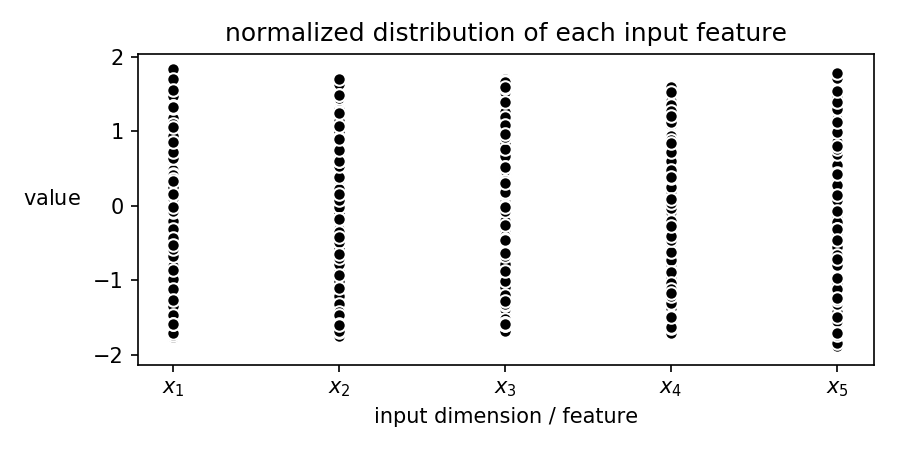

In [1210]:
# use the plotting function above
title = 'normalized distribution of each input feature'
feature_distributions(x_norm,y,title)

Much better!  With each input distribution normalized and roughly looking the same we can intuit, no individual weight $w_n$ will be significantly more sensitive (to proper tuning) than the others, so we can expect gradient descent to have a much easier time here.

**TO DO**

Compare the performance of gradient descent in tuning the Least Squares cost function on this dataset when you use the raw dataset versus when you normalize the input.  Use only $25$ iterations of gradient descent in each instance, and in each instance use the largest steplength value $\alpha$ of the form $10^{-\gamma}$ (where $\gamma$ is a positive integer) that produces convergence with an initial point $\mathbf{w}^0 = \begin{bmatrix} 0 \\ \vdots \\ 0 \end{bmatrix}$ at the origin (all zeros).

**You should turn in:**
    
**1)** Completed code blocks for a ``predict`` function with a linear model i.e., 

\begin{equation}
\text{predict}\left(\mathbf{x},\omega\right) = w_0 + w_1x_1 + w_2x_2 + \cdots + w_Nx_N.
\end{equation}


for training purposes in ``Python`` along with a ``least_squares`` implementation


**2)** a cost function plot for each run of gradient descent, along with a sentence comparing the two runs


**3)** You need **not** provide a ``Python`` implementation of the ``predict_testing`` function (defined for the single-input case in Exercise 1) which is used for making predictions using your trained model).  But you must provide its algebraic form - i.e., its equation.  This should be written in a *Markdown* cell in this Jupyter notebook! 


**Hint:**

This is a direct generalization of Exercise 1 - make sure you look at that!  Feel free to steal useful code /markdown chunks from the previous exercise!

In [1211]:
# make our predict function
def predict(x,w):
    return np.sum(w[0] + x*(w[1:]).T, axis=1).reshape(x.shape[0], 1)

In [1212]:
# make predictions for the entire set of inputs simultaneously
w = np.random.randn(6,1)   # make random weights for our prediction
print ('predictions for all our poitns')
print (predict(x,w).T)

predictions for all our poitns
[[-19.14183469   9.33348295  -4.32281944 -21.52681708  -6.23848835
  -10.23064054  -7.86155908 -23.97540335 -18.49346872  -2.36460499
  -20.84995374   0.34207372  -0.80856134   2.56399754  -4.02974759
   -1.79875002  -6.05571732  -6.72560865  -5.83857421  -3.96553843
   -9.10330706 -16.86168827   1.23990706 -20.95776136  -0.60272463
  -12.14022789  -6.36613453  -5.00641945  -3.28169087  -0.44726882
   -8.41594677  -2.20972526  -7.24590157  -9.66924743  -2.74633515
  -14.84250035 -19.1038993   -0.65109049  -7.88528607  -8.23780146
  -16.64251329   7.43259783  -4.91337429 -12.80691781   1.61751458
  -17.70822711   1.14010449  -5.60572394  -5.55756717 -20.87618647
   -4.54996827   1.00466331 -19.605693    -3.41624438   7.07759334
   -3.57641019  -6.47900098  -7.03541027   2.07200877   1.57168058
   -4.70884185 -18.78310687   4.75080615  -5.15474885  16.96928596
    5.16011048 -21.13313601  -8.89654289  10.39826648  -5.82866072
    4.44077235  -6.53572095 -11

In [1213]:
# least squares
least_squares = lambda w: np.sum((predict(x,w) - y)**2)

<IPython.core.display.Javascript object>


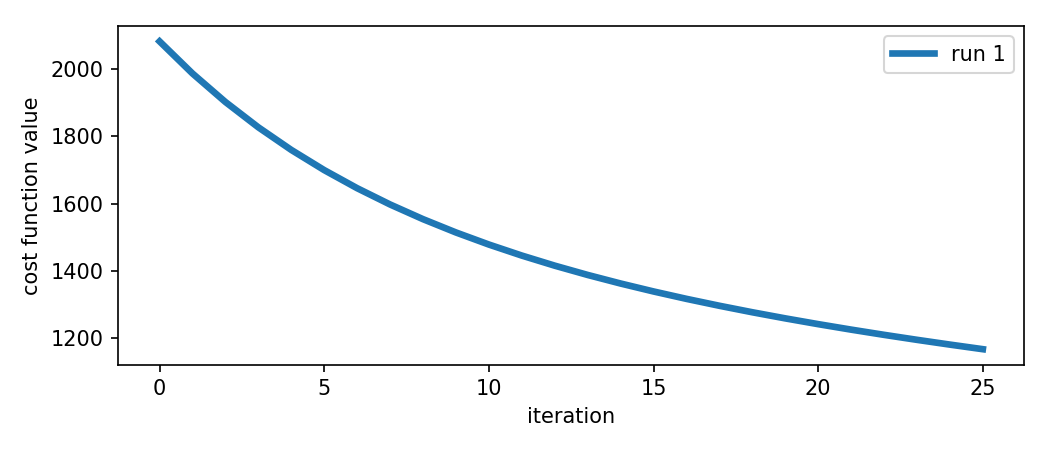

In [1214]:
# run gradient descent initialized at 0
alpha = 10**(-6)
max_its = 25
w_init = np.zeros((6,1))

# run gradient descent
weight_history = gradient_descent(least_squares,w_init,alpha,max_its,beta = 0,version = 'unnormalized')

# plot cost function history
cost_history = [least_squares(v) for v in weight_history]
histories = [cost_history]
demo = util.Visualizer()
demo.compare_regression_histories(histories)

In [1215]:
# compute the mean and standard deviation of the input
x_mean = np.mean(x)
x_std = np.std(x)

In [1216]:
# a normalization function 
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/data_std
    return normalized_data

In [1217]:
# cache a copy of the original input, then normalize
x_orig = copy.deepcopy(x)
x = normalize(x,x_mean,x_std)

<IPython.core.display.Javascript object>


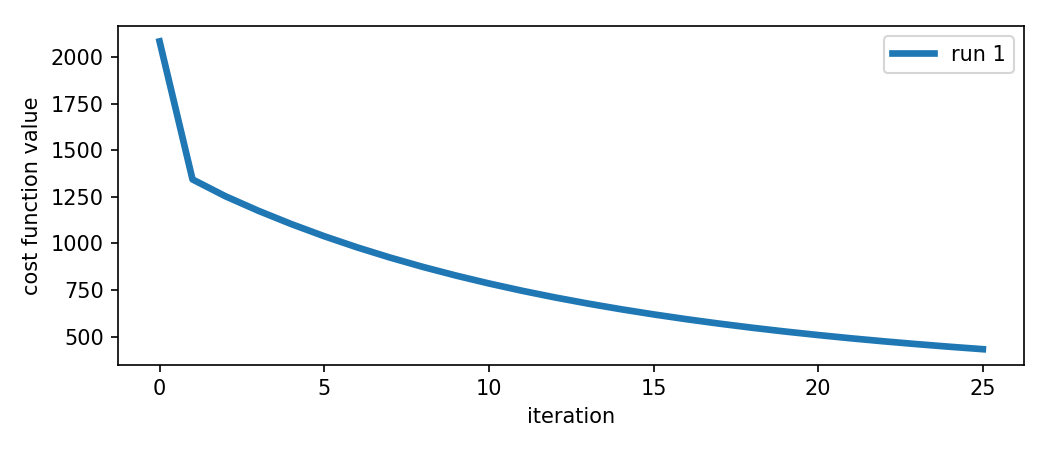

In [1218]:
# run gradient descent initialized at 0
alpha = 10**(-4)
max_its = 25
w_init = np.zeros((6,1))

# run gradient descent
weight_history = gradient_descent(least_squares,w_init,alpha,max_its,beta = 0,version = 'unnormalized')

# plot cost function history
cost_history = [least_squares(v) for v in weight_history]
histories = [cost_history]
demo.compare_regression_histories(histories)

In [1219]:
# By doing the input normalization, it reached the convergence with less iterations.
# In other words, it takes less time to reach the minimum cost value. 
# Also, based on the two plotting graphs, the plotting curve after the input normalization is much better compared to the one before the input formalization.
# (normalization made the cost function to treat the slope and bias more equivalently, and speeds up the gradient descent)

Algebraic form of predict_testing function in case of input normalization

\begin{equation}
\text{predict_testing}\left(x,\omega\right) = w_0 + w_1\left(\frac{x_1 - \mu_1}{\sigma_1}\right) + w_2\left(\frac{x_2 - \mu_2}{\sigma_2}\right) + w_3\left(\frac{x_3 - \mu_3}{\sigma_3}\right) + w_4\left(\frac{x_4 - \mu_4}{\sigma_4}\right) + w_5\left(\frac{x_5 - \mu_5}{\sigma_5}\right)
\end{equation}